In [15]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.utils import save_image
from torch.cuda.amp import autocast, GradScaler
from google.colab import drive
import zipfile

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

folder_path = '/content/drive/MyDrive/DL_CA'
os.listdir(folder_path)

['img_align_celeba.zip']

In [5]:
zip_file_path = '/content/drive/MyDrive/DL_CA/img_align_celeba.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_file_list = zip_ref.namelist()
    print(zip_file_list[:10])

['img_align_celeba/', 'img_align_celeba/000001.jpg', 'img_align_celeba/000002.jpg', 'img_align_celeba/000003.jpg', 'img_align_celeba/000004.jpg', 'img_align_celeba/000005.jpg', 'img_align_celeba/000006.jpg', 'img_align_celeba/000007.jpg', 'img_align_celeba/000008.jpg', 'img_align_celeba/000009.jpg']


In [6]:
import zipfile
import os
extract_folder = '/content/celeba_images'
os.makedirs(extract_folder, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Extraction terminée.")


Extraction terminée.


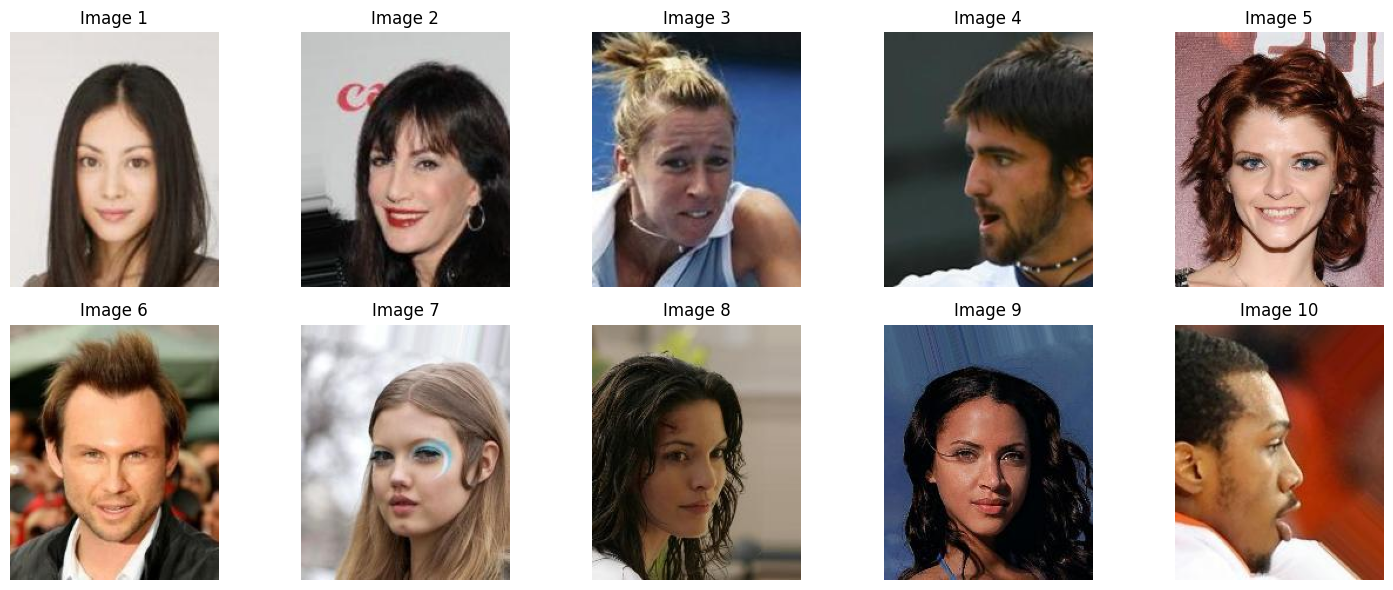

In [8]:
from PIL import Image
import matplotlib.pyplot as plt

subfolder_path = os.path.join(extract_folder, 'img_align_celeba')

image_files = os.listdir(subfolder_path)[:10]

# Afficher les 10 premières images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, image_file in enumerate(image_files):
    image_path = os.path.join(subfolder_path, image_file)
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1}")

# Afficher les images
plt.tight_layout()
plt.show()


In [ ]:
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(UNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet, self).__init__()
        self.conv1 = UNetBlock(in_channels, 16)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = UNetBlock(16, 32)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = UNetBlock(32, 64)
        self.pool3 = nn.MaxPool2d(2)

        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0)
        self.conv4 = UNetBlock(64, 32)

        self.upconv5 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, padding=0)
        self.conv5 = UNetBlock(32, 16)

        self.output_layer = nn.Conv2d(16, out_channels, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        pool1 = self.pool1(conv1)

        conv2 = self.conv2(pool1)
        pool2 = self.pool2(conv2)

        conv3 = self.conv3(pool2)
        pool3 = self.pool3(conv3)

        upconv4 = self.upconv4(pool3)
        crop4 = self.center_crop(conv2, upconv4.size()[2:])
        concat4 = torch.cat([upconv4, crop4], dim=1)
        conv4 = self.conv4(concat4)

        upconv5 = self.upconv5(conv4)
        crop5 = self.center_crop(conv1, upconv5.size()[2:])
        concat5 = torch.cat([upconv5, crop5], dim=1)
        conv5 = self.conv5(concat5)

        output = self.output_layer(conv5)
        output = F.interpolate(output, size=(256, 256), mode='bilinear', align_corners=False)
        return output

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]


In [ ]:
class DiffusionStep(nn.Module):
    def __init__(self, noise_std=0.1):
        super(DiffusionStep, self).__init__()
        self.noise_std = noise_std

    def forward(self, x):
        noise = torch.randn_like(x) * self.noise_std
        diffused_x = x + noise
        return diffused_x

class DiffusionModel(nn.Module):
    def __init__(self, diffusion_step, unet_model, num_steps=5):
        super(DiffusionModel, self).__init__()
        self.diffusion_steps = nn.ModuleList([diffusion_step() for _ in range(num_steps)])
        self.unet_model = unet_model

    def forward(self, x):
        for diffusion_step in self.diffusion_steps:
            x = diffusion_step(x)
        x = self.unet_model(x)
        return x

In [ ]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, file) for file in os.listdir(root_dir) if file.endswith(".jpg")]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image, 0

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = CelebADataset(root_dir='/content/celeba_images/img_align_celeba', transform=transform)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)


In [ ]:
unet = UNet()
diffusion_model = DiffusionModel(DiffusionStep, unet, num_steps=5)

learning_rate = 0.001
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
diffusion_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(diffusion_model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scaler = GradScaler()


In [13]:
for epoch in range(num_epochs):
    for images, _ in tqdm(data_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images = images.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = diffusion_model(images)
            loss = criterion(outputs, images)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    scheduler.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

    if (epoch + 1) % 5 == 0:
        model_save_path = os.path.join(model_dir, f'diffusion_model_epoch_{epoch + 1}.pth')
        torch.save(diffusion_model.state_dict(), model_save_path)
        print(f"Model saved at {model_save_path}")


<ipython-input-13-c703abc47f94>:143: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Automatic mixed precision
Epoch 1/10:   0%|          | 0/3166 [00:00<?, ?it/s]<ipython-input-13-c703abc47f94>:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10: 100%|██████████| 3166/3166 [02:40<00:00, 19.76it/s]


Epoch 1/10, Loss: 0.007773514837026596


Epoch 2/10: 100%|██████████| 3166/3166 [03:01<00:00, 17.41it/s]


Epoch 2/10, Loss: 0.008388620801270008


Epoch 3/10: 100%|██████████| 3166/3166 [02:39<00:00, 19.81it/s]


Epoch 3/10, Loss: 0.006427085027098656


Epoch 4/10: 100%|██████████| 3166/3166 [02:39<00:00, 19.84it/s]


Epoch 4/10, Loss: 0.005895774811506271


Epoch 5/10: 100%|██████████| 3166/3166 [02:56<00:00, 17.92it/s]


Epoch 5/10, Loss: 0.005509445443749428
Model saved at models/diffusion_model_epoch_5.pth


Epoch 6/10: 100%|██████████| 3166/3166 [02:40<00:00, 19.71it/s]


Epoch 6/10, Loss: 0.005446499679237604


Epoch 7/10: 100%|██████████| 3166/3166 [02:41<00:00, 19.63it/s]


Epoch 7/10, Loss: 0.005071560852229595


Epoch 8/10: 100%|██████████| 3166/3166 [02:56<00:00, 17.91it/s]


Epoch 8/10, Loss: 0.004345565102994442


Epoch 9/10: 100%|██████████| 3166/3166 [02:40<00:00, 19.72it/s]


Epoch 9/10, Loss: 0.004597772844135761


Epoch 10/10: 100%|██████████| 3166/3166 [02:40<00:00, 19.69it/s]

Epoch 10/10, Loss: 0.004555038176476955
Model saved at models/diffusion_model_epoch_10.pth


In [16]:
# Reverse Diffusion Process: Start from Noise and Denose Gradually
def reverse_diffusion(noise_image, model, num_steps=5):
    """
    Perform reverse diffusion starting from random noise. """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        generated_image = noise_image  # Start with random noise

        for t in range(num_steps):
            # Reverse the diffusion step
            generated_image = model(generated_image)

    return generated_image


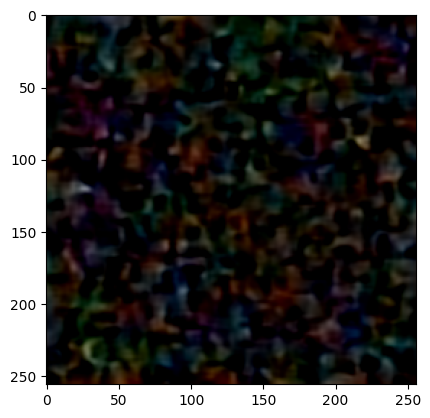

In [18]:
# Generate an image from random noise using reverse diffusion
noise_image = torch.randn(1, 3, 256, 256).to(device)  # Starting with random noise

# Run reverse diffusion
generated_image = reverse_diffusion(noise_image, diffusion_model, num_steps=5)

# Convert the output to a numpy array for visualization
generated_image = generated_image.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0)

# Show the generated image
plt.imshow(generated_image)
plt.show()